In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from PIL import Image

%matplotlib inline

In [22]:
haar = cv2.CascadeClassifier('../data/haarcascade_frontalface_default.xml')

'''
Takes root image path and extracts all the faces
from the images in the directory. Then takes the 
processed faces and puts them in the processed_images
folder in the same directory
'''
def get_faces(image_path):
    images_path = glob(f"{image_path}/*")
    image_name = 1
    images_with_face = 0
    images_without_face = 0
    total_images = 0
    print(f"Attempting to process {len(images_path)} images")
    
    for path in images_path:
        #print(f"Processing {path}")
        if not 'jpg' in path.lower() and not 'png' in path.lower():
            print(f"Skipped {path}")
            continue
            
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = haar.detectMultiScale(gray, 2,2)
        #print(f"{len(faces)} faces found")
        total_images += 1
        if len(faces) > 0:
            #print(f"Writing {image_path}/processed_images/{image_name}.png with first face")
            x,y,h,w = faces[0]
            cv2.rectangle(image, (x,y),(x+w,y+h),(0,255,0),5)
            cropped_image = image[y:y+h,x:x+w]
            cv2.imwrite(f"{image_path}/processed_images/{image_name}.png", cropped_image)
            images_with_face += 1
            image_name += 1
        else:
            images_without_face += 1
    print(f"Total images processed {total_images} Images with faces {images_with_face} Images without faces {images_without_face}")

In [23]:
'''
Takes root image path and plots all the
processed images in the folder
'''
def plot_processed_images(image_path):
    processed_images = glob(f"{image_path}/processed_images/*")
    plt.figure(figsize=(15,6))
    plt.subplot(1,len(processed_images),1)
    current_image = 1
    for path in processed_images:
        plt.title(path.split('/')[-1])
        image = cv2.imread(path)
        plt.imshow(image)
        plt.subplot(1,len(processed_images),current_image)
        current_image += 1
    plt.show()

Attempting to process 7 images
Skipped ../data/me_random/processed_images
Total images processed 6 Images with faces 5 Images without faces 1


<ipython-input-23-decf833aa4ae>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,len(processed_images),current_image)


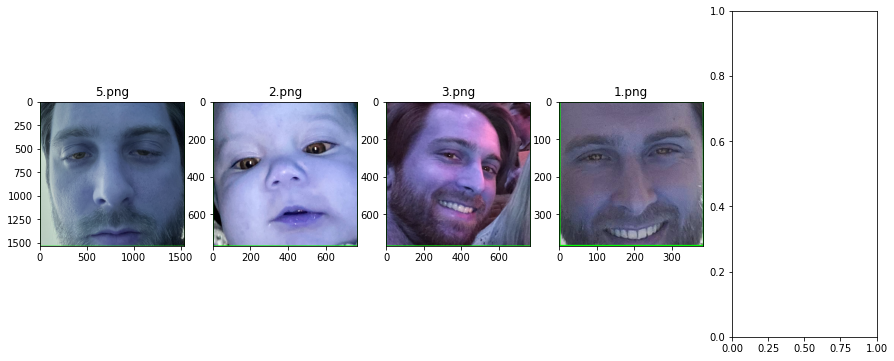

In [24]:
# Process random images
image_path = '../data/me_random'
get_faces(image_path)
plot_processed_images(image_path)

In [25]:
def face_detect(image):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 2,2)
    
    for x,y,w,h in faces:
        cv2.rectangle(image, (x,y), (x+w,y+h),(0, 255,255),10)
    
    return image

In [26]:
# Extract images from calibration video frames

def extract_images_from_video(video_path):
    cap = cv2.VideoCapture(video_path)

    frames = 0
    while True:
        ret,frame = cap.read()
        if ret == False:
            print(f"Processed {frames} frames")
            break

        frame = face_detect(frame)
        cv2.imwrite(f"../data/calibration_images/{frames}.png", frame)
        frames += 1

    cap.release()

In [27]:
#extract_images_from_video('../data/calibration.mp4')

In [28]:
# Process calibration video images
image_path = '../data/calibration_images'
get_faces(image_path)

Attempting to process 200 images
Skipped ../data/calibration_images/processed_images
Total images processed 199 Images with faces 59 Images without faces 140


<ipython-input-23-decf833aa4ae>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,len(processed_images),current_image)


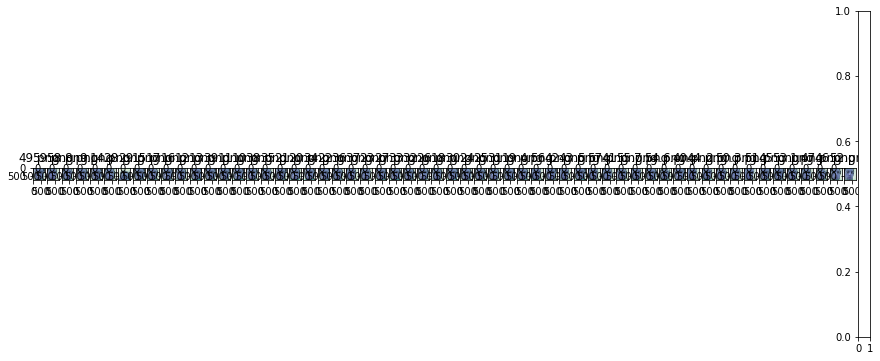

In [29]:
plot_processed_images(image_path)

In [56]:
def get_image_size(path):
    image = Image.open(path)
    return image.size[0]

In [57]:
# Preprocess calibration images
calibration_images = glob('../data/calibration_images/processed_images/*')

In [58]:
# Get image size
image = Image.open(calibration_images[0])
image.size

(768, 768)

In [59]:
# Resize images with pandas
df = pd.DataFrame(data=calibration_images,columns=['path'])
df.shape

(59, 1)

In [60]:
df['size'] = df['path'].apply(get_image_size)
df.head()

,path,size
0,../data/calibration_images/processed_images/48...,768
1,../data/calibration_images/processed_images/49...,768
2,../data/calibration_images/processed_images/59...,768
3,../data/calibration_images/processed_images/58...,768
4,../data/calibration_images/processed_images/8.png,768


In [61]:
df.describe()

,size
count,59.000000
mean,767.728814
std,1.460167
min,760.000000
25%,768.000000
50%,768.000000
75%,768.000000
max,768.000000


<AxesSubplot:>

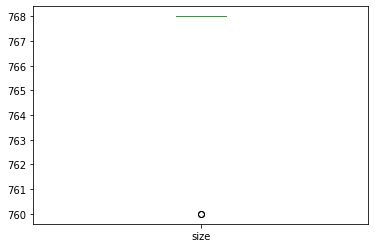

In [62]:
df['size'].plot(kind='box')

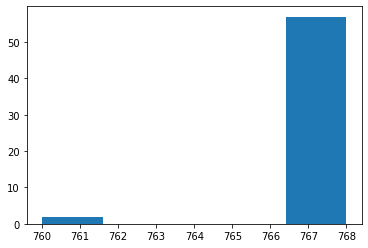

In [63]:
plt.hist(df['size'],bins=5)
plt.show()

In [65]:
# Remove unnecessary images
df_new = df[df['size']>765]

In [68]:
df_new.size

114

In [69]:
df.size

118

In [73]:
# Resize images
def flatten_image(path):
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    size = gray.shape[0]
    if size > 100:
        gray_resize = cv2.resize(gray, (100,100), cv2.INTER_AREA) # shrink
    else:
        gray_resize = cv2.resize(gray, (100,100), cv2.INTER_CUBIC)
    flat_image = gray_resize.flatten()
    return flat_image

In [74]:
len(flatten_image(calibration_images[0]))

10000

In [75]:
df_new['flat_image'] = df_new['path'].apply(flatten_image)

<ipython-input-75-d0184e220882>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flat_image'] = df_new['path'].apply(flatten_image)


In [76]:
df_new.head()

,path,size,flat_image
0,../data/calibration_images/processed_images/48...,768,"[159, 176, 176, 176, 176, 176, 176, 176, 176, ..."
1,../data/calibration_images/processed_images/49...,768,"[159, 176, 176, 176, 176, 176, 176, 176, 176, ..."
2,../data/calibration_images/processed_images/59...,768,"[159, 176, 176, 176, 176, 176, 176, 176, 176, ..."
3,../data/calibration_images/processed_images/58...,768,"[159, 173, 173, 165, 153, 141, 135, 131, 133, ..."
4,../data/calibration_images/processed_images/8.png,768,"[159, 176, 176, 176, 176, 176, 176, 176, 176, ..."


In [78]:
df1 = df_new['flat_image'].apply(pd.Series)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,159,176,176,176,176,176,176,176,176,176,...,226,226,226,226,226,226,226,226,226,226
1,159,176,176,176,176,176,176,176,176,176,...,226,226,226,226,226,226,226,226,226,226
2,159,176,176,176,176,176,176,176,176,176,...,211,210,210,210,210,209,209,208,208,226
3,159,173,173,165,153,141,135,131,133,136,...,226,226,226,226,226,226,226,226,226,226
4,159,176,176,176,176,176,176,176,176,176,...,224,224,223,222,221,221,220,219,218,226


In [81]:
df_expanded = pd.concat((df_new['path'],df1),axis=1)
df_expanded.head()

,path,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,../data/calibration_images/processed_images/48...,159,176,176,176,176,176,176,176,176,...,226,226,226,226,226,226,226,226,226,226
1,../data/calibration_images/processed_images/49...,159,176,176,176,176,176,176,176,176,...,226,226,226,226,226,226,226,226,226,226
2,../data/calibration_images/processed_images/59...,159,176,176,176,176,176,176,176,176,...,211,210,210,210,210,209,209,208,208,226
3,../data/calibration_images/processed_images/58...,159,173,173,165,153,141,135,131,133,...,226,226,226,226,226,226,226,226,226,226
4,../data/calibration_images/processed_images/8.png,159,176,176,176,176,176,176,176,176,...,224,224,223,222,221,221,220,219,218,226


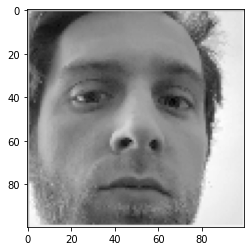

In [83]:
plt.imshow(df_expanded.loc[0][1:].values.reshape(100,100).astype('int'), cmap='gray')

In [84]:
import pickle

In [85]:
# Save dataframe
pickle.dump(df_expanded, open('../data/dataframe_images_100_100.pickle', 'wb'))

In [87]:
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 58
Columns: 10001 entries, path to 9999
dtypes: object(1), uint8(10000)
memory usage: 559.6+ KB


In [96]:
# Check if there are missing values
df_expanded.isnull().sum()

path    0
0       0
1       0
2       0
3       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Length: 10001, dtype: int64

In [97]:
df_expanded.head()

,path,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,../data/calibration_images/processed_images/48...,159,176,176,176,176,176,176,176,176,...,226,226,226,226,226,226,226,226,226,226
1,../data/calibration_images/processed_images/49...,159,176,176,176,176,176,176,176,176,...,226,226,226,226,226,226,226,226,226,226
2,../data/calibration_images/processed_images/59...,159,176,176,176,176,176,176,176,176,...,211,210,210,210,210,209,209,208,208,226
3,../data/calibration_images/processed_images/58...,159,173,173,165,153,141,135,131,133,...,226,226,226,226,226,226,226,226,226,226
4,../data/calibration_images/processed_images/8.png,159,176,176,176,176,176,176,176,176,...,224,224,223,222,221,221,220,219,218,226


In [101]:
X = df_expanded.iloc[:,1:].values # independent values
Y = df_expanded.iloc[:,0].values # dependent values

In [103]:
X.shape

(57, 10000)

# Min Max Scaling
## Xnorm = $\frac {x - minValue} {maxValue - minValue}$

In [104]:
X.min(), X.max()

(10, 254)

In [107]:
Xnorm = (X - X.min()) / (X.max() - X.min())

In [108]:
Xnorm

array([[0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.81147541, 0.81147541,
        0.8852459 ],
       ...,
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ]])

In [109]:
Xnorm.shape

(57, 10000)

In [111]:
np.savez('../data/x_norm_100_100.npz',Xnorm)

In [112]:
data = np.load('../data/x_norm_100_100.npz')

In [116]:
data['arr_0']

array([[0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.81147541, 0.81147541,
        0.8852459 ],
       ...,
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ],
       [0.61065574, 0.68032787, 0.68032787, ..., 0.8852459 , 0.8852459 ,
        0.8852459 ]])